In [185]:
import pandas as pd
import numpy as np
import os
import shutil
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer, confusion_matrix
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# Aim
To predict whether a customer will stop using a service (customer churn). This is done using XGBoost algorithm.

The dataset taken is the **Telco customer churn IBM dataset** taken from kaggle.

# download dataset

In [4]:
py_dir = os.getcwd()

In [5]:
if os.getcwd() != "C:\\Users\\AJIN RUFUS\\.kaggle":
    os.chdir("C:\\Users\\AJIN RUFUS\\.kaggle")

In [12]:
dt_name = "telco-customer-churn-ibm-dataset"

# !kaggle datasets list -s "Telco customer churn: IBM datase"

!kaggle datasets download -d "yeanzc/telco-customer-churn-ibm-dataset"

In [13]:
shutil.move(os.getcwd() + f"\\{dt_name}.zip", py_dir)

'C:\\Users\\AJIN RUFUS\\Downloads\\pandas\\statistics\\telco-customer-churn-ibm-dataset.zip'

In [15]:
os.chdir(py_dir + f"\\{dt_name}")

In [142]:
df = pd.read_excel("./Telco_customer_churn.xlsx")

In [143]:
df.head() # MTE - mid term exam, ETM - end term exam

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


# handle missing data

In [144]:
# since we need to predict whether the customer will stop using the serive or not, churn reason, CLTV, churn score

df.drop(["Churn Label", "Churn Score", "CLTV", "Churn Reason"], axis =1, inplace = True)

In [145]:
# Some values have only one value, therefore not useful for making prediction
df["Count"].unique()

df["Country"].unique()

df["State"].unique()

df["CustomerID"].unique() # remove unique values for each data
df["Lat Long"].unique()

df.drop(["Count", "Country", "State",  "CustomerID", "Lat Long"], axis =1, inplace = True)

In [146]:
df.head()

,City,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,Los Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,Los Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


For drawing trees, there should be no white spaces in the data

In [147]:
df["City"].replace(" ", "_", regex=True, inplace=True)

In [148]:
df.columns = df.columns.str.replace(" ", "_")

# handle missing data

In [149]:
# identifying
df.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges         object
Churn_Value            int64
dtype: object

In [150]:
df["Total_Charges"].unique()

array([108.15, 151.65, 820.5, ..., 7362.9, 346.45, 6844.5], dtype=object)

In [151]:
df.loc[df["Total_Charges"] == " "]

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
2234,San_Bernardino,92408,34.084909,-117.258107,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,0
2438,Independence,93526,36.869584,-118.189241,Male,No,No,No,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,0
2568,San_Mateo,94401,37.590421,-122.306467,Female,No,Yes,No,0,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,0
2667,Cupertino,95014,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,0
2856,Redcrest,95569,40.363446,-123.835041,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,0
4331,Los_Angeles,90029,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,0
4687,Sun_City,92585,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,0
5104,Ben_Lomond,95005,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,0
5719,La_Verne,91750,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,0
6772,Bell,90201,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,0


We can see that the total charges is " " because the tenure months is 0. Therefore, no charge is being mae. therefore replace the empty space with 0.

In [152]:
df.loc[df["Total_Charges"] == " ", "Total_Charges"] = 0

In [153]:
df["Total_Charges"] = pd.to_numeric(df["Total_Charges"]) # string to numeric

In [154]:
df.replace(" ", "_", regex=True, inplace =True)    # replace all values that have blank spaces

# Separate attribute and output

In [170]:
x = df.drop("Churn_Value", axis = 1) # attrbutes

y = df["Churn_Value"]     # output required to be predicted

# one hot encoding

* city - cities
* zip
* senior citizen
* partner
* dependents
* phone service
* multiple lines - yes/no
* internet service - no,dsl, fibre
* online backup - yes/no
* device protection - yes/no
* tech support
* streaming TV
* Streaming movies - yes/no
* contract - monthly, yearly bi-yearly
* paperless billing - yes/no
* payment method - mail cheque, electronic cheque ...

Since above are categorie, we need to do one hot encoding.

In [171]:
x_enc = pd.get_dummies(x, columns=["Payment_Method", "City",
                          "Gender", "Senior_Citizen",
                          "Partner", "Dependents",
                          "Phone_Service", "Multiple_Lines",
                          "Internet_Service", "Online_Security",
                          "Online_Backup", "Device_Protection",
                          "Tech_Support", "Streaming_TV",
                           "Streaming_Movies", "Contract",
                           "Paperless_Billing"])

x_enc.head() # most columns is due to city names

,Zip_Code,Latitude,Longitude,Tenure_Months,Monthly_Charges,Total_Charges,Payment_Method_Bank_transfer_(automatic),Payment_Method_Credit_card_(automatic),Payment_Method_Electronic_check,Payment_Method_Mailed_check,...,Streaming_TV_No_internet_service,Streaming_TV_Yes,Streaming_Movies_No,Streaming_Movies_No_internet_service,Streaming_Movies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,Paperless_Billing_No,Paperless_Billing_Yes
0,90003,33.964131,-118.272783,2,53.85,108.15,False,False,False,True,...,False,False,True,False,False,True,False,False,False,True
1,90005,34.059281,-118.307420,2,70.70,151.65,False,False,True,False,...,False,False,True,False,False,True,False,False,False,True
2,90006,34.048013,-118.293953,8,99.65,820.50,False,False,True,False,...,False,True,False,False,True,True,False,False,False,True
3,90010,34.062125,-118.315709,28,104.80,3046.05,False,False,True,False,...,False,True,False,False,True,True,False,False,False,True
4,90015,34.039224,-118.266293,49,103.70,5036.30,True,False,False,False,...,False,True,False,False,True,True,False,False,False,True


XGBoost doesn't allocate memory for 0's and therefore check if memory is allocated for a particular variable or not. Done for saving memory.

# XGBoost model building

Train Test Split

In [173]:
len(y[y== 0])/len(y)

0.7346301292063041

Since there is unequality in the label use stratify while splitting to get equal percentage in training and testing dataset tp avoid bias in modelling and testing

In [174]:
# splitting data into test train data. test = 0.25 is default
x_train, x_test, y_train, y_test = train_test_split(x_enc, y, random_state=42, stratify=y)

In [175]:
len(y_train == 0)/len(y_train)

1.0

In [177]:
len(y_train[y_train == 0])/len(y_train)

0.7345702385460053

In [180]:
xgb_clf = xgb.XGBClassifier(objective = "binary:logistic", missing = 0, seed = 42,
                           early_stopping_round= 10, eval_metric="aucpr") # missing - to give missing value = 0 (default), logistic is the method used

# eval_set - trains usinf training data, but builds the number of trees based on testing data

xgb_clf.fit(x_train, y_train,
            eval_set = [(x_test,y_test)])

[0]	validation_0-aucpr:0.64139
[1]	validation_0-aucpr:0.65161
[2]	validation_0-aucpr:0.66003
[3]	validation_0-aucpr:0.65769
[4]	validation_0-aucpr:0.65817
[5]	validation_0-aucpr:0.65415
[6]	validation_0-aucpr:0.65875
[7]	validation_0-aucpr:0.66285
[8]	validation_0-aucpr:0.66159
[9]	validation_0-aucpr:0.66108
[10]	validation_0-aucpr:0.66028
[11]	validation_0-aucpr:0.66205
[12]	validation_0-aucpr:0.66114
[13]	validation_0-aucpr:0.65998
[14]	validation_0-aucpr:0.65746
[15]	validation_0-aucpr:0.65641
[16]	validation_0-aucpr:0.65939
[17]	validation_0-aucpr:0.65845


C:\Users\AJIN RUFUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:32:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "early_stopping_round" } are not used.

  warnings.warn(smsg, UserWarning)


[18]	validation_0-aucpr:0.65640
[19]	validation_0-aucpr:0.65700
[20]	validation_0-aucpr:0.65662
[21]	validation_0-aucpr:0.65608
[22]	validation_0-aucpr:0.65606
[23]	validation_0-aucpr:0.65446
[24]	validation_0-aucpr:0.65333
[25]	validation_0-aucpr:0.65340
[26]	validation_0-aucpr:0.65318
[27]	validation_0-aucpr:0.65185
[28]	validation_0-aucpr:0.65253
[29]	validation_0-aucpr:0.65231
[30]	validation_0-aucpr:0.65176
[31]	validation_0-aucpr:0.65027
[32]	validation_0-aucpr:0.65055
[33]	validation_0-aucpr:0.64987
[34]	validation_0-aucpr:0.65074
[35]	validation_0-aucpr:0.65073
[36]	validation_0-aucpr:0.65168
[37]	validation_0-aucpr:0.65027
[38]	validation_0-aucpr:0.65253
[39]	validation_0-aucpr:0.65036
[40]	validation_0-aucpr:0.64829
[41]	validation_0-aucpr:0.64874
[42]	validation_0-aucpr:0.64784
[43]	validation_0-aucpr:0.64822
[44]	validation_0-aucpr:0.64629
[45]	validation_0-aucpr:0.64601
[46]	validation_0-aucpr:0.64572
[47]	validation_0-aucpr:0.64399
[48]	validation_0-aucpr:0.64174
[49]	val

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_round=10,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='aucpr', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=0, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [181]:
y_pred = xgb_clf.predict(x_test) # predicting the testing dataset

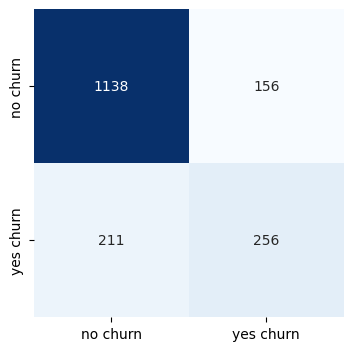

In [186]:
cm = confusion_matrix(y_test, y_pred) # confusion matrix

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['no churn', 'yes churn'], yticklabels=['no churn', 'yes churn'])
plt.show()

# Optimising the arguments

One of the problem for this error is due to bias in the data. So we have to deal with imbalanced data. Use **scale_pos_weight** attribute to penalise more if the tree is calssifying the minority class wrongly.

Also we can manually alter,
* Max depth - depth of the tree
* Learning rate
* regularisation parameter
* gamma

In [205]:
params = {"max_depth":[3,4,5],
          "learning_rate":[0.1,0.025,0.05],
          "gamma":[0.25,1],
          "reg_lambda":[0.5, 1,2],
          "scale_pos_weight":[1,1.5, 3]}

In [206]:
opt_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective = "binary:logistic", missing = 0, seed = 42,
                           early_stopping_round= 10, eval_metric="aucpr", colsample_bytree=0.5),
    param_grid=params,
    scoring ="roc_auc",
    verbose = 0,
    n_jobs = 10,
    cv=3)

In [207]:
opt_params.fit(x_train, y_train,
            eval_set = [(x_test,y_test)])

[0]	validation_0-aucpr:0.51870
[1]	validation_0-aucpr:0.60135
[2]	validation_0-aucpr:0.63487
[3]	validation_0-aucpr:0.64082
[4]	validation_0-aucpr:0.64250
[5]	validation_0-aucpr:0.64154
[6]	validation_0-aucpr:0.64410
[7]	validation_0-aucpr:0.64203
[8]	validation_0-aucpr:0.64665
[9]	validation_0-aucpr:0.64921
[10]	validation_0-aucpr:0.65013
[11]	validation_0-aucpr:0.65193
[12]	validation_0-aucpr:0.64958
[13]	validation_0-aucpr:0.65050
[14]	validation_0-aucpr:0.65444
[15]	validation_0-aucpr:0.65664


C:\Users\AJIN RUFUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:01:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "early_stopping_round" } are not used.

  warnings.warn(smsg, UserWarning)


[16]	validation_0-aucpr:0.65745
[17]	validation_0-aucpr:0.65729
[18]	validation_0-aucpr:0.65624
[19]	validation_0-aucpr:0.65662
[20]	validation_0-aucpr:0.65636
[21]	validation_0-aucpr:0.65645
[22]	validation_0-aucpr:0.65487
[23]	validation_0-aucpr:0.65605
[24]	validation_0-aucpr:0.65614
[25]	validation_0-aucpr:0.65669
[26]	validation_0-aucpr:0.65596
[27]	validation_0-aucpr:0.65705
[28]	validation_0-aucpr:0.65788
[29]	validation_0-aucpr:0.65748
[30]	validation_0-aucpr:0.65796
[31]	validation_0-aucpr:0.65885
[32]	validation_0-aucpr:0.66037
[33]	validation_0-aucpr:0.66040
[34]	validation_0-aucpr:0.65884
[35]	validation_0-aucpr:0.65881
[36]	validation_0-aucpr:0.65647
[37]	validation_0-aucpr:0.65812
[38]	validation_0-aucpr:0.65832
[39]	validation_0-aucpr:0.65930
[40]	validation_0-aucpr:0.65898
[41]	validation_0-aucpr:0.65762
[42]	validation_0-aucpr:0.65728
[43]	validation_0-aucpr:0.65738
[44]	validation_0-aucpr:0.65804
[45]	validation_0-aucpr:0.65709
[46]	validation_0-aucpr:0.65938
[47]	val

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5, device=None,
                                     early_stopping_round=10,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='aucpr', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraint...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=0, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=10,
             param_grid={'gamma': [0.25, 1],
                         'learning_rate': [0.1, 0.025, 0.05],
                         'max_depth': [3, 4, 5], 'reg_lambda': [0.5, 1, 2],
                         'scale_pos_weight': [1, 1.5, 3]},
             scoring='roc_auc')

In [208]:
opt_dict = opt_params.best_params_
opt_dict

{'gamma': 0.25,
 'learning_rate': 0.05,
 'max_depth': 4,
 'reg_lambda': 2,
 'scale_pos_weight': 1}

In [209]:
xgb_clf = xgb.XGBClassifier(objective = "binary:logistic", missing = 0, seed = 42,
                           early_stopping_round= 10, eval_metric="aucpr",
                           gamma=opt_dict["gamma"] , learn_rate=opt_dict["learning_rate"],
                           max_depth= opt_dict["max_depth"], reg_lambda= opt_dict["reg_lambda"],
                           scale_pos_weight = opt_dict["scale_pos_weight"]) # missing - to give missing value = 0 (default), logistic is the method used

# eval_set - trains usinf training data, but builds the number of trees based on testing data

xgb_clf.fit(x_train, y_train,
            eval_set = [(x_test,y_test)])

[0]	validation_0-aucpr:0.59853
[1]	validation_0-aucpr:0.61143
[2]	validation_0-aucpr:0.63668
[3]	validation_0-aucpr:0.64051
[4]	validation_0-aucpr:0.65956
[5]	validation_0-aucpr:0.66356
[6]	validation_0-aucpr:0.66801
[7]	validation_0-aucpr:0.67087
[8]	validation_0-aucpr:0.67095
[9]	validation_0-aucpr:0.67313
[10]	validation_0-aucpr:0.67699
[11]	validation_0-aucpr:0.67304
[12]	validation_0-aucpr:0.67315
[13]	validation_0-aucpr:0.67154
[14]	validation_0-aucpr:0.67136
[15]	validation_0-aucpr:0.67198
[16]	validation_0-aucpr:0.67302
[17]	validation_0-aucpr:0.67143
[18]	validation_0-aucpr:0.67110


C:\Users\AJIN RUFUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:01:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "early_stopping_round", "learn_rate" } are not used.

  warnings.warn(smsg, UserWarning)


[19]	validation_0-aucpr:0.67092
[20]	validation_0-aucpr:0.67044
[21]	validation_0-aucpr:0.66973
[22]	validation_0-aucpr:0.66845
[23]	validation_0-aucpr:0.66758
[24]	validation_0-aucpr:0.66761
[25]	validation_0-aucpr:0.66757
[26]	validation_0-aucpr:0.66779
[27]	validation_0-aucpr:0.66770
[28]	validation_0-aucpr:0.66537
[29]	validation_0-aucpr:0.66518
[30]	validation_0-aucpr:0.66554
[31]	validation_0-aucpr:0.66290
[32]	validation_0-aucpr:0.66290
[33]	validation_0-aucpr:0.66244
[34]	validation_0-aucpr:0.66258
[35]	validation_0-aucpr:0.66235
[36]	validation_0-aucpr:0.66241
[37]	validation_0-aucpr:0.66202
[38]	validation_0-aucpr:0.66202
[39]	validation_0-aucpr:0.66144
[40]	validation_0-aucpr:0.66111
[41]	validation_0-aucpr:0.66122
[42]	validation_0-aucpr:0.66007
[43]	validation_0-aucpr:0.66007
[44]	validation_0-aucpr:0.65756
[45]	validation_0-aucpr:0.65452
[46]	validation_0-aucpr:0.65240
[47]	validation_0-aucpr:0.65411
[48]	validation_0-aucpr:0.65174
[49]	validation_0-aucpr:0.65134
[50]	val

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_round=10,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='aucpr', feature_types=None, gamma=0.25,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learn_rate=0.05, learning_rate=None,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=0, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, ...)

In [210]:
y_pred = xgb_clf.predict(x_test)

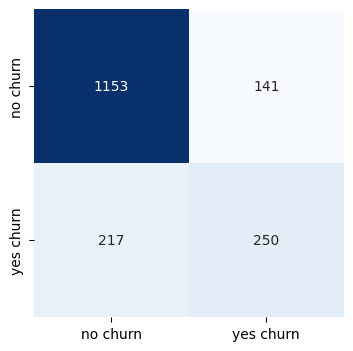

In [211]:
cm = confusion_matrix(y_test, y_pred) # confusion matrix

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['no churn', 'yes churn'], yticklabels=['no churn', 'yes churn'])
plt.show()

Not much improvement has been observed

Accuracy score

In [212]:
# overall accuracy - dtc.score(x_test, y_test)
acc = (cm[0,0] + cm[-1,-1])/np.sum(cm) * 100
acc

79.67064168086314

Sensitivity

In [213]:
# sensitivity
sensitivity = cm[-1,-1]/ np.sum(cm[1])
sensitivity

0.5353319057815846

Specificity

In [214]:
specificity = cm[0,0]/np.sum(cm[0]) # recall
specificity

0.8910355486862442

# Result:
From the above results we can see that the XGBoost seems to give relatively good accuracy (79.67%). But the sensitivty seems to be very low. This could be due to the imbalanced proportion of churned and no churned data in the dataset.